In [1]:
import symnum
import symnum.numpy as snp
import sympy
import numpy as np
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [2]:
import sys
#sys.path.append('/Users/yugaiguchi/Library/Python/3.8/lib/python')
sys.path.append('/Users/yugaiguchi/Research/Development/GitHub/Dev_Hypo/Untitled')
import simsde

In [3]:
# x[0], x[1], x[2]: extended space (rough), x[3]: momentum, x[4]:position
# unit mass (M = 1), d_r = 3, d_X = 5. dim_bm = 3

def drift_position(x, θ):
    return snp.array([x[3]])

def drift_momentum(x, θ):
    λ_1, λ_2, λ_3, *_ = θ
    # the potential function q -> V(q) is assumed to be V(q) = q^2 /2 
    return snp.array([- x[2] + λ_1*x[0] + λ_2*x[1] + λ_3*x[2]])

def diff_coeff_rough(x, θ):
    *_, α_1, α_2, α_3, β = θ
    σ_1 = snp.sqrt(2*α_1/β)
    σ_2 = snp.sqrt(2*α_2/β) 
    σ_3 = snp.sqrt(2*α_3/β) 
    return snp.array([[σ_1, 0, 0], [0, σ_2, 0], [0, 0, σ_3]])

def drift_rough(x, θ):
    λ_1, λ_2, λ_3, α_1, α_2, α_3, *_ = θ
    return snp.array([
        - λ_1*x[3] - α_1*x[0], 
        - λ_2*x[3] - α_2*x[1], 
        - λ_3*x[3] - α_3*x[2]
    ])

def drift_smooth(x, θ):
    return snp.concatenate((drift_momentum(x, θ), drift_position(x, θ)))

def drift_func(x, θ):
    return snp.concatenate((drift_rough(x, θ), drift_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 6
dim_s1 = 1
dim_s2 = 1
dim_r = 3
dim_θ = 7
dim_w = 3
# x = snp.array(sympy.symbols('s_t, p_t, q_t'))
# x_0 = snp.array(sympy.symbols('s_0, p_0, q_0'))
# θ = snp.array(sympy.symbols('λ, α, β')) 
# t = snp.array(sympy.symbols('t'))
# n = snp.array(sympy.symbols('n, 0, 0'))
# Σ = diff_coeff(x, θ)
# density = simsde.densities.local_gaussian_log_transition_density_ii(drift_position, drift_momentum, drift_rough, diff_coeff_rough)(x, x_0, θ, t)
# drift_q = drift_position(x, θ)
# drift_p = drift_momentum(x, θ)
# drift = drift_func(x, θ)
# display(Σ)
# display(drift)
# display(density)
# display(drift) 


Text(0.5, 0, 'Time')

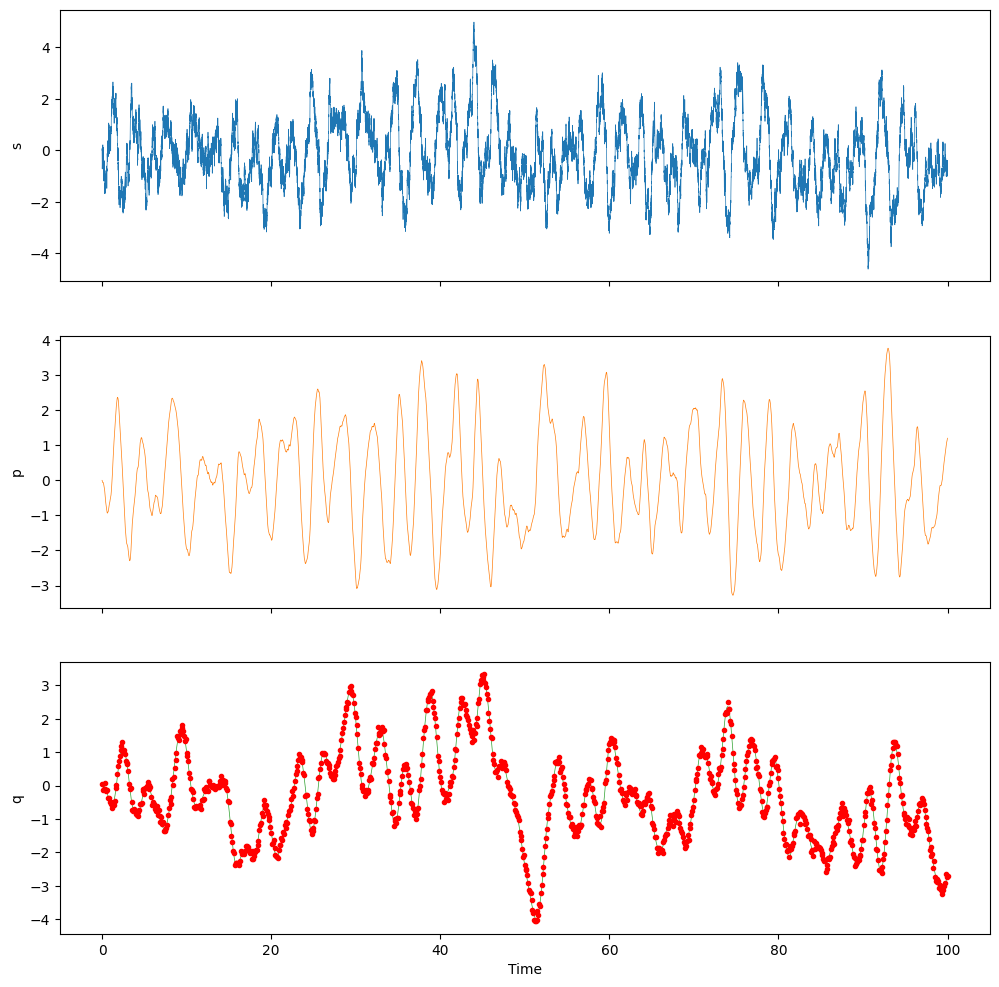

In [88]:
dim_u = 7
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [ 
            jnp.exp(u[0]),  # λ_1
            jnp.exp(u[1]),  # λ_2
            jnp.exp(u[2]),  # λ_3 
            jnp.exp(u[3]),  # α_1
            jnp.exp(u[4]),  # α_2
            jnp.exp(u[5]),  # α_3 
            jnp.exp(u[6]),  # β  
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([0.00, 0.00, 0.00])
    
# assume we only observe the position (q_t)
def obs_func(x_seq):
    return (x_seq[:, 6])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"λ_1": θ[0], "λ_2": θ[1], "λ_3": θ[2], "α_1": θ[3], "α_2": θ[4], "α_3": θ[5], "β": θ[6]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500): # -500 is default

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_r
    ),
    "local_gaussian_ii": (
        simsde.integrators.hypoelliptic_ii_local_gaussian_step(drift_func, drift_rough, drift_position, drift_momentum, diff_coeff_rough),
        3*dim_r
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 1e-4
t_max = 20.
dt_observation = 0.1
t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
obs_time_indices_simulation = slice(None, None, int(dt_observation / dt_simulation))

simulation_method = "local_gaussian_ii"

rng_obs = np.random.default_rng(20221111)
obs_noise_std = 0.1
x_0_obs = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
θ_obs = np.array([1, 2, 1, 16, 32, 16, 0.5])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[obs_time_indices_simulation])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'spq' # s: extended variable (rough component), p: momentum, q: position
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, x_seq_obs[:, i], color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[2].plot(t_seq_simulation[obs_time_indices_simulation], y_obs, 'r.')
axes[-1].set_xlabel('Time')


euler_maruyama
0.05


Sampling stage: Adaptive warm up [04:01] > Main non-adaptive [06:35]

Chain 1/4: 100%|██████████|1000/1000 [00:00<00:00, 1115.20it/s, n_step=1.00, accept_stat=0.00]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 2/4: 100%|██████████|1000/1000 [02:12<00:00, 7.56it/s, n_step=1.02e+03, accept_stat=0.936]

Chain 3/4: 100%|██████████|1000/1000 [02:11<00:00, 7.59it/s, n_step=1.02e+03, accept_stat=0.942]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 4/4: 100%|██████████|1000/1000 [02:10<00:00, 7.67it/s, n_step=1.02e+03, accept_stat=0.933]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.212,1.848,-1.959,2.930,0.920,0.704,5.0,31.0,2.73
α,0.951,0.484,0.169,1.485,0.226,0.171,7.0,4.0,1.54
β,1.167,0.990,0.485,2.876,0.492,0.377,7.0,1101.0,1.53


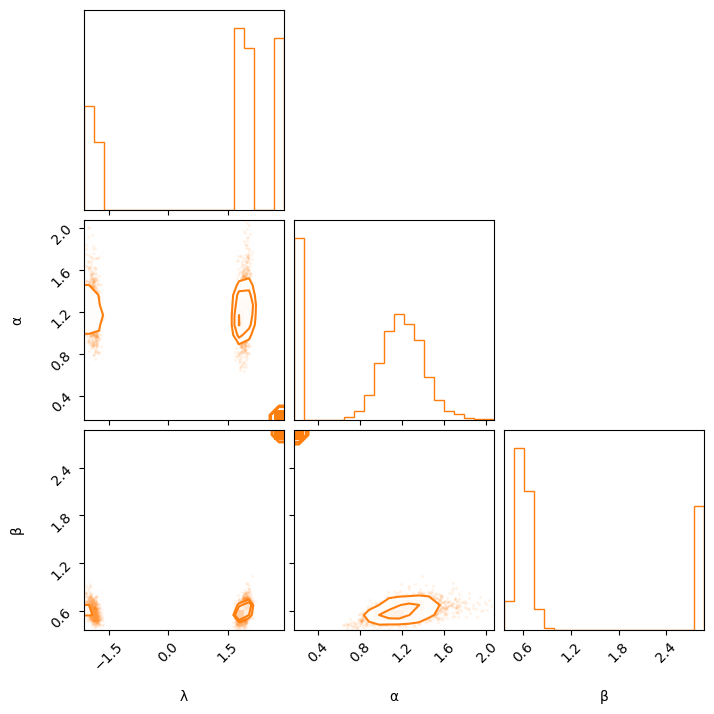

local_gaussian_ii
0.05


Sampling stage: Adaptive warm up [05:40] > Main non-adaptive [12:07]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/systems.py:257: RuntimeWarning: overflow encountered in matmul
  return 0.5 * state.mom @ self.dh2_dmom(state)


Chain 1/4: 100%|██████████|1000/1000 [03:02<00:00, 5.47it/s, n_step=1.02e+03, accept_stat=0.877]

Chain 2/4: 100%|██████████|1000/1000 [03:00<00:00, 5.53it/s, n_step=1.02e+03, accept_stat=0.876]

Chain 3/4: 100%|██████████|1000/1000 [03:03<00:00, 5.46it/s, n_step=1.02e+03, accept_stat=0.876]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [03:00<00:00, 5.53it/s, n_step=1.02e+03, accept_stat=0.876]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,-0.947,1.640,-2.024,1.968,0.816,0.625,7.0,32.0,1.53
α,1.077,0.194,0.728,1.437,0.007,0.005,818.0,1607.0,1.00
β,0.516,0.076,0.379,0.665,0.002,0.002,1256.0,2288.0,1.00


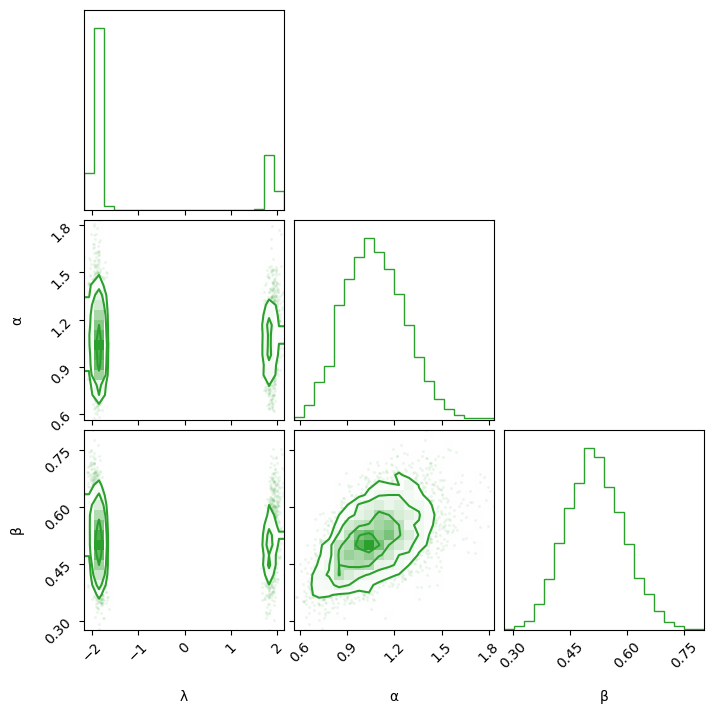

euler_maruyama
0.02


Sampling stage: Adaptive warm up [07:59] > Main non-adaptive [16:55]

Chain 1/4: 100%|██████████|1000/1000 [04:15<00:00, 3.91it/s, n_step=1.02e+03, accept_stat=0.880]

Chain 2/4: 100%|██████████|1000/1000 [04:11<00:00, 3.98it/s, n_step=1.02e+03, accept_stat=0.885]

Chain 3/4: 100%|██████████|1000/1000 [04:15<00:00, 3.91it/s, n_step=1.02e+03, accept_stat=0.882]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


Chain 4/4: 100%|██████████|1000/1000 [04:12<00:00, 3.96it/s, n_step=1.02e+03, accept_stat=0.862]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.912,0.077,1.763,2.055,0.003,0.002,779.0,1600.0,1.0
α,1.086,0.202,0.727,1.481,0.008,0.005,728.0,1478.0,1.0
β,0.520,0.082,0.378,0.683,0.003,0.002,947.0,1779.0,1.0


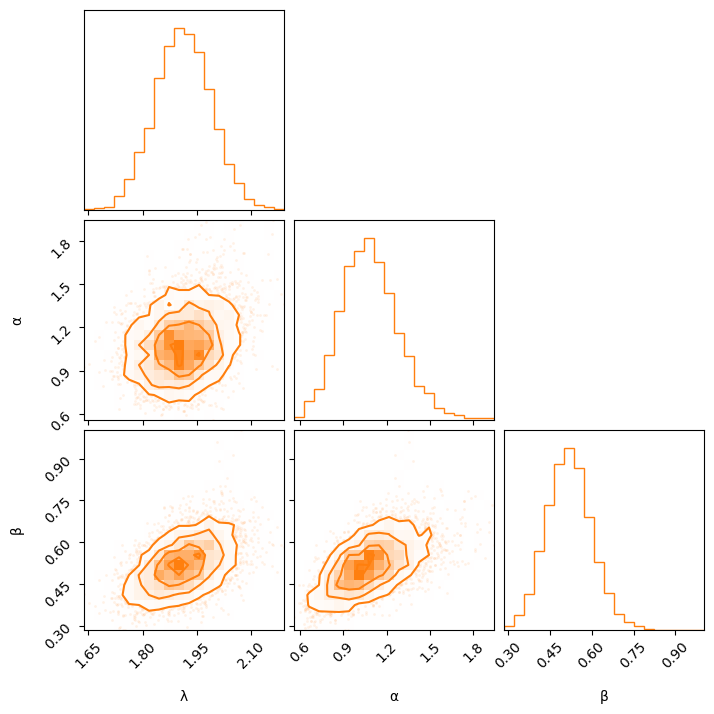

local_gaussian_ii
0.02


Sampling stage: Adaptive warm up

Chain 1/4: 100%|██████████|500/500 [02:58<00:00, 2.81it/s, n_step=964., accept_stat=0.798]

Chain 2/4: 100%|██████████|500/500 [04:51<00:00, 1.71it/s, n_step=964., accept_stat=0.803]

Chain 3/4:  28%|███       |145/500 [01:24<03:26, 1.72it/s, n_step=927., accept_stat=0.802]

/Users/yugaiguchi/Library/Python/3.9/lib/python/site-packages/mici/transitions.py:570: RuntimeWarning: overflow encountered in exp
  1, np.exp(aux_vars["h_init"] - h)


In [89]:
n_chain = 4
#n_warm_up_iter = 1000
n_warm_up_iter = 500
n_main_iter = 1000
#dt_inference_seq = np.array([0.04, 0.02, 0.01])
dt_inference_seq = np.array([0.05, 0.02, 0.01]) 
trace = [[] for i in range(2)]

for dt_inference in dt_inference_seq:
    color = 1
    for key, generate_x_seq in generate_x_seq_functions.items():
        print(key)
        print(dt_inference)
        #dt_inference = 200 * dt_simulation
        t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
        obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

        common_kwargs = {
            "generate_θ": generate_θ,
            "generate_x_0": generate_x_0,
            "obs_func": obs_func,
            "t_seq": t_seq_inference,
            "dim_u": dim_u,
            "dim_v_0": dim_v_0,
            "obs_noise_std": 0.1,
            "obs_time_indices": obs_time_indices,
            "y_obs": y_obs
        }

        posterior_density_functions = get_posterior_density_functions(
            generate_x_seq=generate_x_seq, **common_kwargs
        )
        dim_q = (
            common_kwargs["dim_u"] 
            + common_kwargs["dim_v_0"]
            + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
        )
        rng = np.random.default_rng(20230227)
        system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
        integrator = mici.integrators.LeapfrogIntegrator(system)
        sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
        adapters = [
            mici.adapters.DualAveragingStepSizeAdapter(0.8),
        ]
        init_states = []
        while len(init_states) < n_chain:
            q = rng.standard_normal(dim_q)
            g, v = system._grad_neg_log_dens(q)
            if not (np.any(np.isnan(g)) or np.isnan(v)):
                init_states.append(q)
        final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
            n_warm_up_iter=n_warm_up_iter,
            n_main_iter=n_main_iter,
            init_states=init_states,
            monitor_stats=["n_step", "accept_stat"],
            trace_funcs=[trace_func],
            adapters=adapters,
        )
        summary = arviz.summary(traces)
        fig = corner.corner(traces, 
            # bins = 100, 
            # range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
            # #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
            color=f'C{color}',
            #truth_color="C3"
        )
        display(summary)
        display(fig)
        plt.close(fig)
        trace[color-1].append(traces)
        color += 1


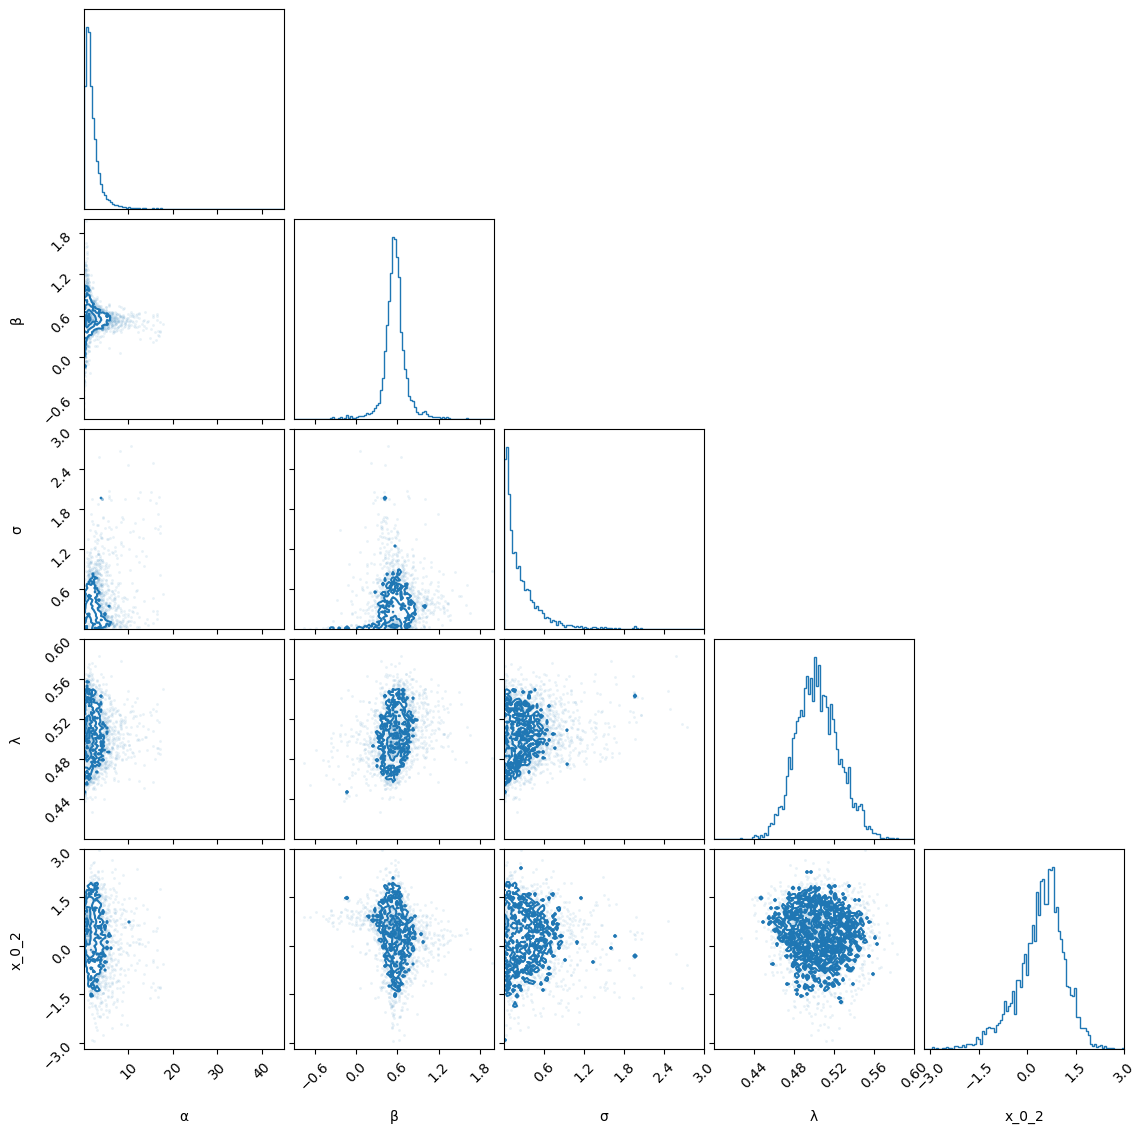

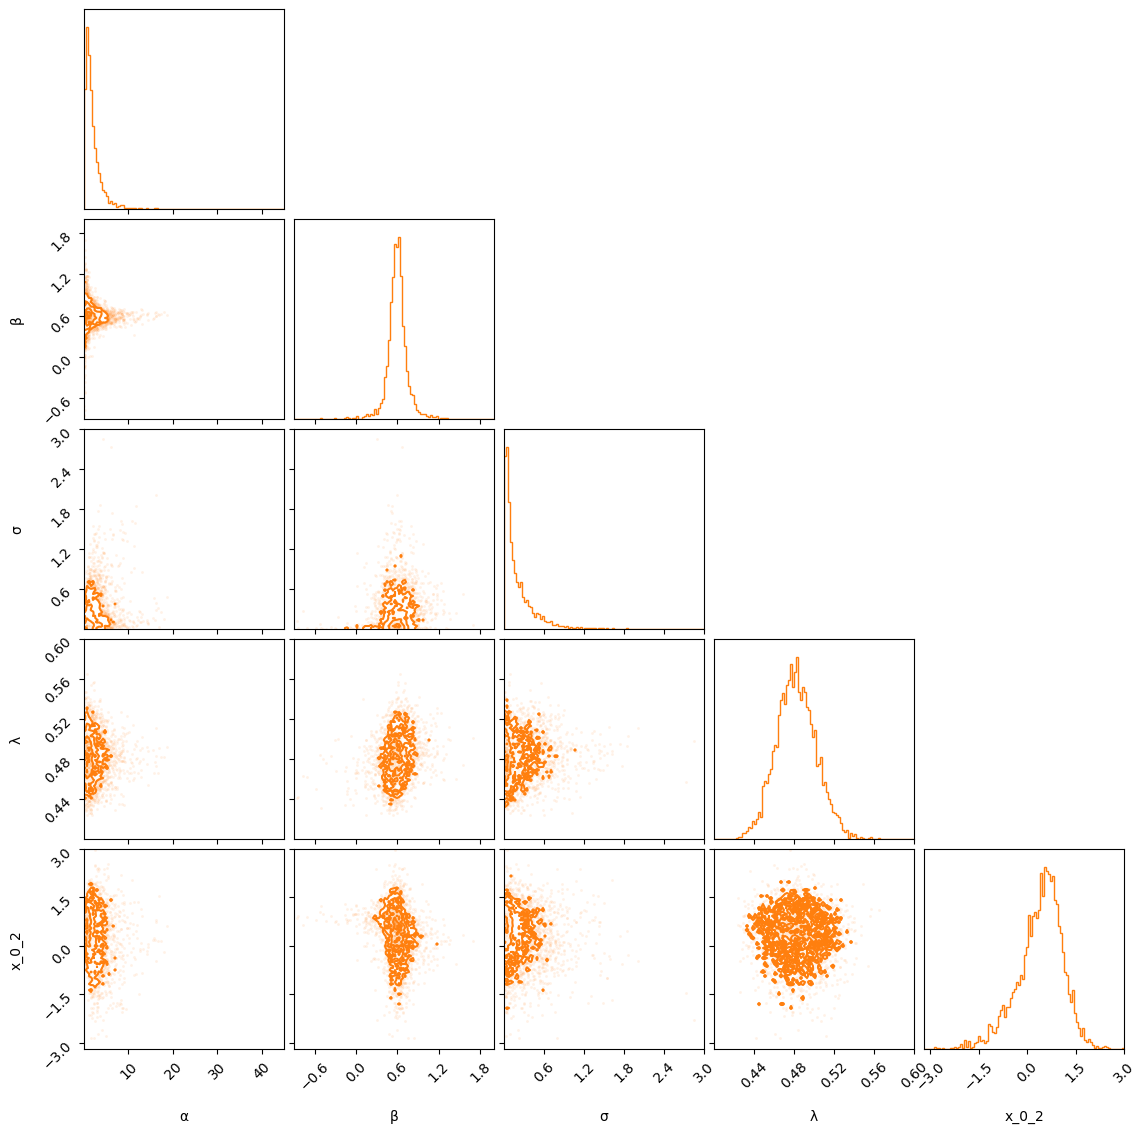

In [ ]:

for color in range(2):
    fig = corner.corner(trace[color][0], 
                #range = [(0.0, 45.0), (-0.9, 2.0), (0, 3.0), (0.40, 0.60), (-3.2, 3.0)], 
                #bins=100,
                #truths= [2.04, 0.592, 0.10, 0.505, np.log(1.25)],
                color=f'C{color}'
            )
    display(fig)
    plt.close(fig)